# Sequential Minimal Optimization

## The Negative ETA Case

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions

%matplotlib widget


In [2]:

def linear_kernel(x1, x2):
    return x1.T @ x2

class svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        self.eps = 0.001
        
        if self._kernel == 'linear':
            self._k = linear_kernel
            
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])
            

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x) 
            u -= self._b

        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        # TODO: the negative case
        else:
            print(f"[DEBUG] smo_step: eta = {eta}")
            
            f1 = (y1*(e1 + self._b)) - (alpha1 * k11) - (s*alpha2*k12)
            f2 = (y2*(e2 + self._b)) - (s*alpha1*k12) - (alpha2*k22)
            L1 = alpha1 + s*(alpha2 - L)
            H1 = alpha1 + s*(alpha2 - H)
            
            Lobj = (L1*f1) + (L*f2) + (0.5*(L1**2)*k11) + (0.5*(L**2)*k22) + (s*L*L1*k12)
            Hobj = (H1*f1) + (H*f2) + (0.5*(H1**2)*k11) + (0.5*(H**2)*k22) + (s*H*H1*k12)
            
            if (Lobj < Hobj- self.eps):
                a2 = L
            elif (Lobj > (Hobj + self.eps)):
                  a2 = H
            else:
                  a2 = alpha2
            
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i in range(self._data.shape[0]):
                    if i == i2:
                        continue
                    if self.smo_step(i, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

In [3]:
n_a_samples = 50
n_b_samples = 50

a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples)
b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples)
a_targets = np.ones(n_a_samples) * -1  # Samples from class A are assigned a class value of -1.
b_targets = np.ones(n_b_samples)  # Samples from class B are assigned a class value of 1.

samples = np.concatenate((a_samples, b_samples))
targets = np.concatenate((a_targets, b_targets))
print(samples.shape, targets.shape)

(100, 2) (100,)


In [4]:
model = svm(c=5.0)
model.fit(samples, targets)
print(model._weights)
print(model._b)

[ 1.30930671 -0.43889607]
-0.12471171251265888


weights=[ 1.30930671 -0.43889607]
b=-0.12471171251265888


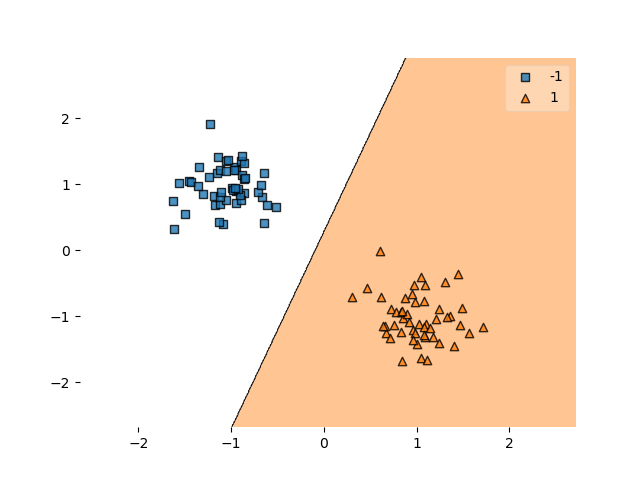

In [5]:
# for i in range(samples.shape[0]):
#     print(f"Sample {i}: score={model.predict_score(samples[i])}, alpha={model._alphas[i]}")


print(f"weights={model._weights}")
print(f"b={model._b}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), model)
fig.add_subplot(ax)
plt.show()

coef_=[[ 0.97056781 -0.67431199]]
intercept=[0.10815062]


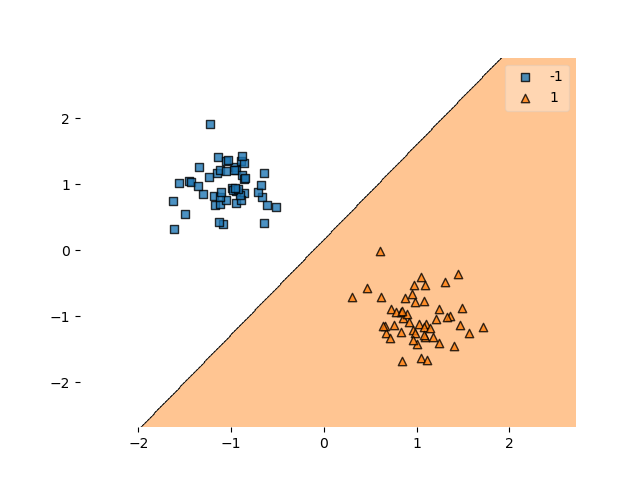

In [6]:
from sklearn.svm import LinearSVC


sk_model = LinearSVC()
sk_model.fit(samples, targets.astype(np.int32))

print(f"coef_={sk_model.coef_}")
print(f"intercept={sk_model.intercept_}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), sk_model)
fig.add_subplot(ax)
plt.show()

## Non-linear SVM

In [7]:
def linear_kernel(x1, x2):
    return x1.T @ x2

def poly_kernel(x1, x2, d = 2, c = 0):
    return (x1 @ x2.T + c)**d


class p_svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        self.eps = 0.001
        
        if self._kernel == 'linear':
            self._k = linear_kernel
        elif self._kernel == 'poly':
            self._k = poly_kernel
        
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x)
            u -= self._b
        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        # TODO: the negative case
        else:
            print(f"[DEBUG] smo_step: eta = {eta}")
            
            f1 = (y1*(e1 + self._b)) - (alpha1 * k11) - (s*alpha2*k12)
            f2 = (y2*(e2 + self._b)) - (s*alpha1*k12) - (alpha2*k22)
            L1 = alpha1 + s*(alpha2 - L)
            H1 = alpha1 + s*(alpha2 - H)
            
            Lobj = (L1*f1) + (L*f2) + (0.5*(L1**2)*k11) + (0.5*(L**2)*k22) + (s*L*L1*k12)
            Hobj = (H1*f1) + (H*f2) + (0.5*(H1**2)*k11) + (0.5*(H**2)*k22) + (s*H*H1*k12)
            
            if (Lobj < Hobj- self.eps):
                a2 = L
            elif (Lobj > (Hobj + self.eps)):
                  a2 = H
            else:
                  a2 = alpha2
                    
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i in range(self._data.shape[0]):
                    if i == i2:
                        continue
                    if self.smo_step(i, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

In [19]:
def _accuracy_score(y_pred,y):
    y_pred = [1 if pred == -1. else 0 for pred in y_pred]
    
    accuracy = np.sum(y == y_pred)/len(y)
    
    return accuracy

## Dataset

In [8]:
#Generating Non-linear data

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=500, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=0)

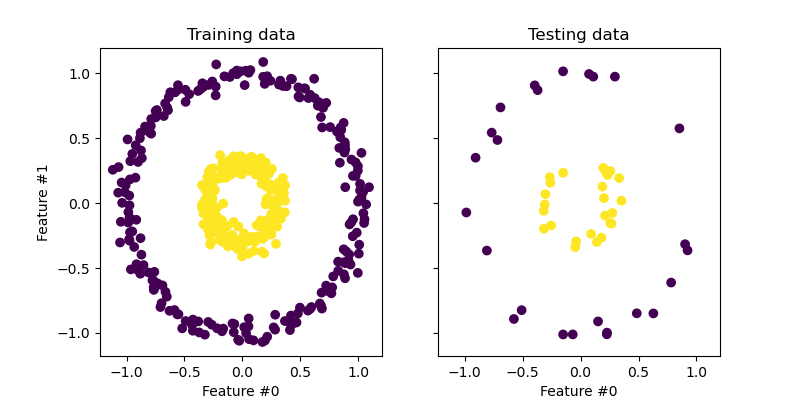

In [9]:
import matplotlib.pyplot as plt

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

## sklearn.SVC with linear kernel

coef_=[[-1.41066491  0.00310126]]
intercept=[0.50648098]
Accuracy of linear svc =  0.62


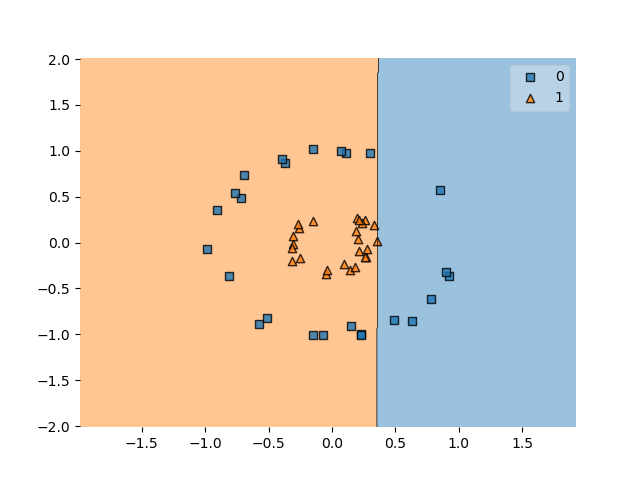

In [10]:
### Using SVC with linear kernel to classify non_linear data 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

l_svc = SVC(kernel = 'linear')
l_svc.fit(X_train, y_train.astype(np.int32))

print(f"coef_={l_svc.coef_}")
print(f"intercept={l_svc.intercept_}")

y_pred_linear = l_svc.predict(X_test)

print("Accuracy of linear svc = ", accuracy_score(y_test, y_pred_linear))


fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), l_svc)
fig.add_subplot(ax)
plt.show()

## SVM with Linear kernel

[-8.08094331  1.05091353]
1.1008373584163835
Accuracy of poly svc =  0.56


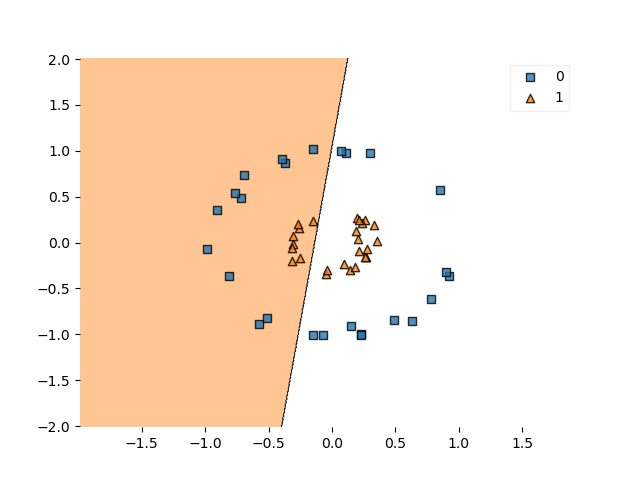

In [22]:
model = svm(c=5.0)
model.fit(X_train, y_train)
print(model._weights)
print(model._b)

y_pred_poly = model.predict(X_test)

print("Accuracy of poly svc = ", _accuracy_score(y_pred_poly,y_test))


fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), model)
fig.add_subplot(ax)
plt.show()


## sklearn.SVC with poly kernel

intercept=[1.56765424]
Accuracy of poly svc =  1.0


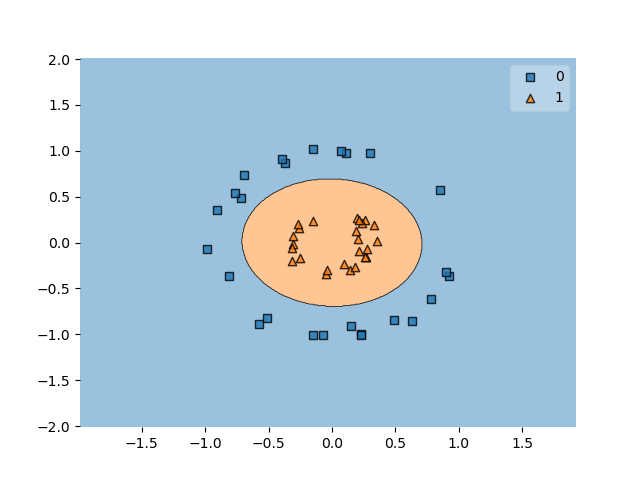

In [11]:
### Using SVC with poly kernel to classify non_linear data 

from sklearn.metrics import accuracy_score

p_svc = SVC(kernel = 'poly', degree = 2)
p_svc.fit(X_train, y_train.astype(np.int32))

#print(f"coef_={p_svc.coef_}")
print(f"intercept={p_svc.intercept_}")

y_pred_poly = p_svc.predict(X_test)

print("Accuracy of poly svc = ", accuracy_score(y_test, y_pred_poly))


fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), p_svc)
fig.add_subplot(ax)
plt.show()

## P_SVM with Poly kernel

7.406700995421142
Accuracy of poly svc =  100.0 %
b=7.406700995421142


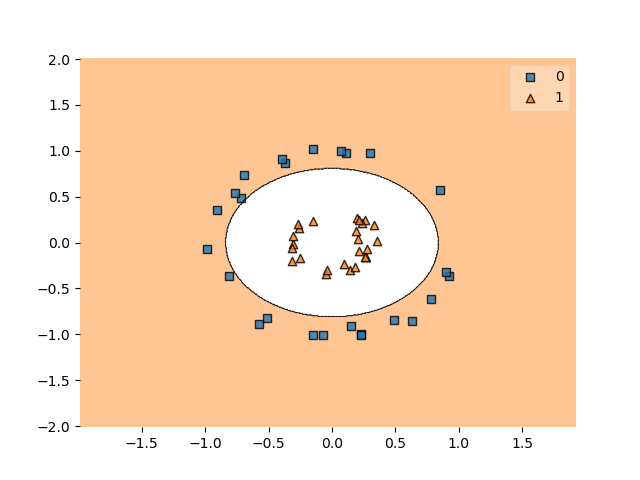

In [23]:
## Using polynomial svm for classification

cls = p_svm(kernel = 'poly')
cls.fit(X_train, y_train)
#print(model._weights)
print(cls._b)

#print(f"intercept={model.intercept_}
p_y_pred = cls.predict(X_test)
print("Accuracy of poly svc = ", (_accuracy_score(p_y_pred, y_test))*100, "%")


#Classification on Training data 
#print(f"weights={model._weights}")
print(f"b={cls._b}")

fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), cls)
fig.add_subplot(ax)
plt.show()